In [1]:
#%matplotlib inline
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 
import scipy.stats
import math
from sklearn.metrics import pairwise
from sklearn.metrics import mean_squared_error

In [138]:
T = 30
N = 200
x_v = 0.01 #gaussian noise in state update
x_r = 0.1 #noise covariance

In [139]:
def f_process(x, t, process_noise):
    return 0.5*x + 25*x/(1 + x**2) + 8*math.cos(1.2*(t-1)) +  np.sqrt(process_noise)*np.random.randn()
def f_observation(x):
    return x**2/20
def generate_data(process_noise, observation_noise, data_len):
    x = np.zeros((data_len,1))
    z = np.zeros((data_len,1))
    for t in range(1,data_len):
        x[t] = f_process(x[t-1], t,process_noise)
        z[t] = f_observation(x[t]) +  np.sqrt(observation_noise)*np.random.randn()
    #plt.figure(figsize=(30,15))
    #plt.plot(z)
    #plt.show()
    #plt.figure(figsize=(30,15))
    #plt.plot(x)
    #plt.show()
    return z, x

In [143]:
def pf_aco(N , logWeights , x_P ):    
    weights = np.exp(logWeights)
    weights = np.exp(weights-np.max(weights))
    weights = weights/np.sum(weights)
    worst = np.argsort(weights)
    worst_idx = worst[0:50] 
    #Assign the initial pheromones as particle weights
    tau = np.zeros((N,N))
    x_P_new = np.zeros_like(x_P)
    for i in range(N):
        tau[:,i] = np.exp(logWeights[i])
    np.fill_diagonal(tau, 0)
    
    #pheromone evaporation rate
    rho = 0.7
    #threshold constant
    t_const = 5
    #deltaT : the amount of pheromone increase when an ant follows a path
    deltaT = 0.5
    #Eta parametresi reciprocal of the distances between particles to be calculated in the loop    
    alpha = 1.0
    beta = 1.0
    #####
    velocity = 0.1;
    
    numOfIts=0
    t_vector = np.zeros((N,1))
    new_tau = np.zeros((N,N))
    threshold = np.zeros(N)
    threshold = (1-weights) * np.abs(np.random.randn(N)) * t_const
    while (numOfIts<6) and (0 in t_vector):
        
        #reciprocal of the distances between particles
        eta = 1/pairwise.pairwise_distances(X=x_P,Y=None,metric='euclidean')
        eta[np.isinf(eta)] = 0
        
        #For all particles, select pj to move towards according the ACO probability
        #Initialize the probability vector
        
        p = np.zeros(N)
        targetIdx = np.zeros((N,1))
        x_P_new = np.copy(x_P);
        new_tau = np.copy(tau)
        for i in range(N):
            #print(tau.shape,eta.shape,x_P.shape)
            p[:] = (tau[i,:]**alpha)*(eta[i,:]**beta)/np.sum((tau[i,:]**alpha)*(eta[i,:]**beta))
            targetIdx[i]= np.argmax(p)
            if  t_vector[i]== 1:
                continue
            aa = np.abs(x_P[int(targetIdx[i])]-x_P[i])
            bb = threshold[int(np.argmax(p))]
            if aa < bb:
                continue
            
            #Move p_i towards target p_j
            x_P_new[i]+=((x_P[int(targetIdx[i])]-x_P[i])/ np.abs((x_P[int(targetIdx[i])]-x_P[i]))) * velocity
            '''
            if i in worst_idx:
                x_P_new[i]=x_P[i]+(x_P[int(targetIdx[i])]-x_P[i])/5
            else:
                x_P_new[i] = x_P[i]
            '''
            
        x_P = np.copy(x_P_new);
        #Update the pheromone levels on the trails
        tau = rho*tau
        for i in range(N):
            
            tau[:,int(targetIdx[i])] = tau[:,int(targetIdx[i])] + deltaT
        
        #Check if all particles are with a certain threshold to their target particle               
        for i in range(N):
            p_tar_Idx = int(targetIdx[i])
            if np.abs(x_P[i]-x_P[p_tar_Idx])<threshold[p_tar_Idx]:
                t_vector[i]=1  
        numOfIts = numOfIts+1
    return x_P      

In [144]:
def bootstap_pf(x_v,x_r,Z,particle_size,T, power_mode = 0):
    x_particle = np.zeros((particle_size,1))
    norm_weights = np.zeros(particle_size)
    log_lik = np.zeros(particle_size)
    x_estimate = np.zeros(T)
    ess = np.zeros(T)
    for t in range(1,T):
        for j in range(particle_size):
            x_particle[j] = f_process(x_particle[j],t,x_v);
            z = f_observation(x_particle[j])
            log_lik[j] = log_lik[j] + np.log(1/np.sqrt(2*np.pi*x_r)) - (Z[t] - z)**2/(2*x_r)
        norm_weights = np.exp(log_lik-np.max(log_lik))
        norm_weights = norm_weights/np.sum(norm_weights)        
        x_estimate[t]  = np.average(x_particle, weights=norm_weights, axis=0)        
        ess[t] = 1/(particle_size*np.sum(norm_weights**2))
        ### Resampling
        if power_mode == 0:
            if ess[t]<0.9:  # Resampling step      
                idx = np.random.choice(range(particle_size), p=norm_weights, size=particle_size)
                x_particle[:] = x_particle[idx]
                log_lik = np.zeros_like(log_lik)  
        if power_mode ==1: #ACO
                x_particle = pf_aco(particle_size , log_lik , x_particle)
                for j in range(particle_size):
                    z = f_observation(x_particle[j])
                    log_lik[j] = log_lik[j] + np.log(1/np.sqrt(2*np.pi*x_r)) - (Z[t] - z)**2/(2*x_r)
                norm_weights = np.exp(log_lik-np.max(log_lik))
                norm_weights = norm_weights/np.sum(norm_weights)
                ess[t] = 1/(particle_size*np.sum(norm_weights**2))
                if ess[t]<0.9:  # Resampling step      
                    x_estimate[t]  = np.average(x_particle, weights=norm_weights, axis=0)   
                    idx = np.random.choice(range(particle_size), p=norm_weights, size=particle_size)
                    x_particle[:] = x_particle[idx]
                    log_lik = np.zeros_like(log_lik)
    return x_estimate

In [145]:
Y = 30
err_aco = np.zeros(Y)
err = np.zeros(Y)
for j in range(Y):
    Z, X = generate_data(x_v,x_r,T)
    M = 5
    total_error = 0
    total_error_aco = 0    
    for i in range(M):
        x_est = bootstap_pf(x_v,x_r,Z,N,T,0)
        total_error += mean_squared_error(X,x_est)
    for i in range(M):
        x_est = bootstap_pf(x_v,x_r,Z,N,T,1)
        total_error_aco += mean_squared_error(X,x_est)
    err_aco[j] = total_error_aco/M
    err[j] = total_error/M


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in true_divide


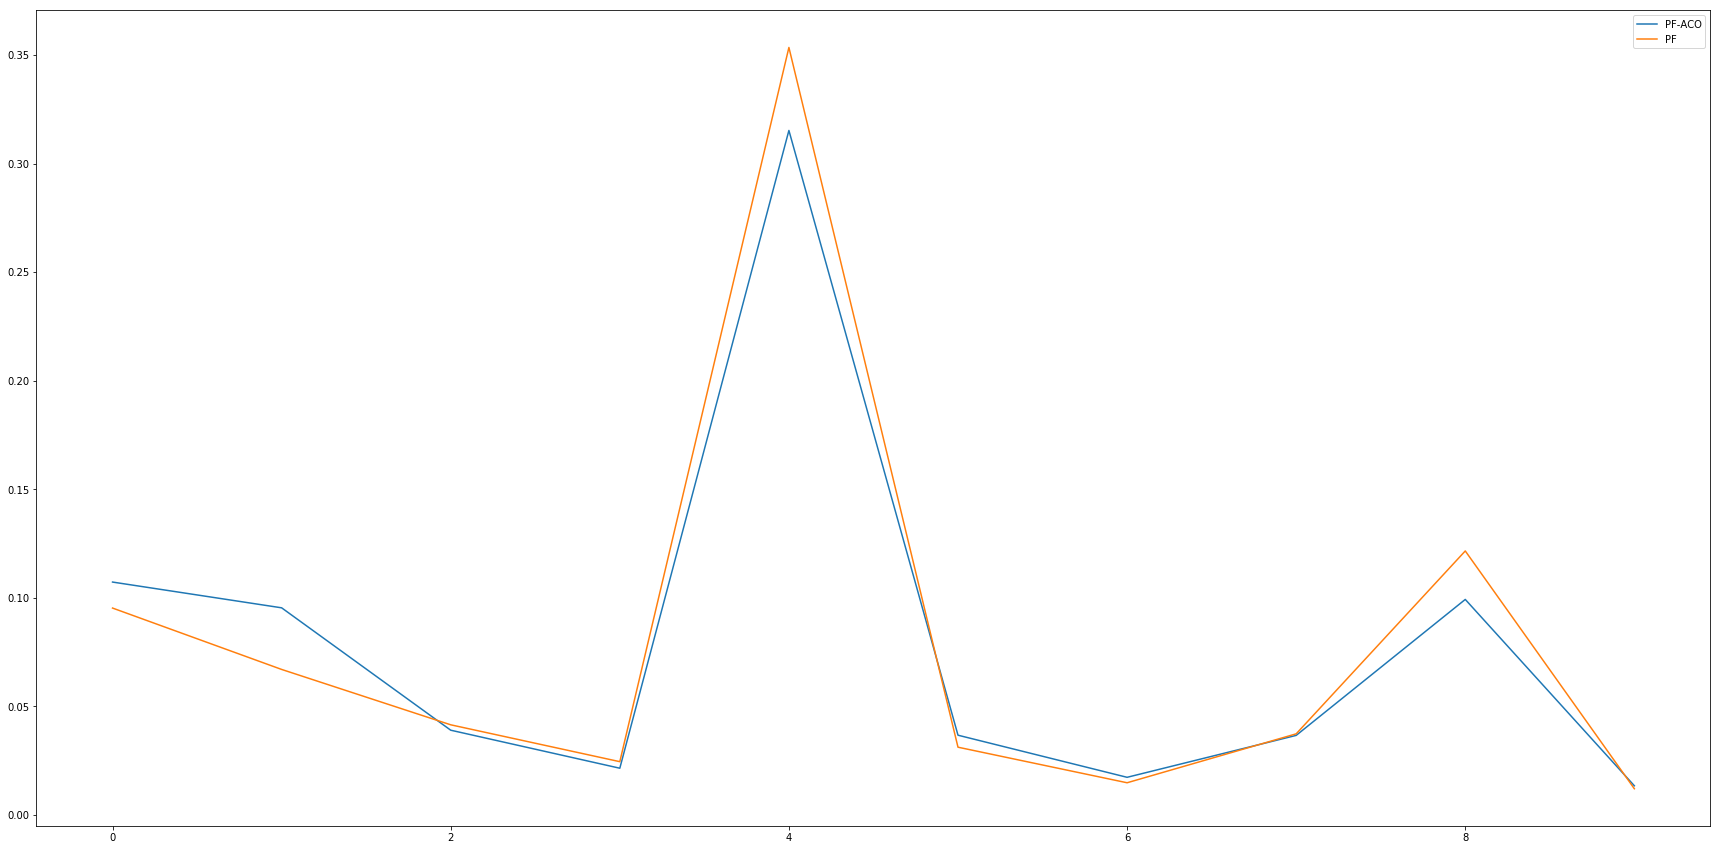

In [146]:
plt.figure(figsize=(30,15))
plt.plot(err_aco,label='PF-ACO')
plt.plot(err,label='PF')
plt.legend()
plt.show()